In [3]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import importlib
import tensorflow as tf
import tensorflow.keras as K
import math, datetime, pandas as pd, numpy as np
import matplotlib.pyplot as plt,random, pickle, glob, os
import sklearn
from PIL import Image
import tarfile
import cv2
import random

## Loading data

Download and extract training data by uncommenting below cell

In [4]:
!wget http://files.fast.ai/data/imagenet-sample-train.tar.gz
fname='imagenet-sample-train.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

--2018-10-06 15:14:07--  http://files.fast.ai/data/imagenet-sample-train.tar.gz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2232645974 (2.1G) [application/x-tar]
Saving to: ‘imagenet-sample-train.tar.gz’

imagenet-sample-tra 100%[===================>]   2.08G   111MB/s    in 19s     

2018-10-06 15:14:26 (110 MB/s) - ‘imagenet-sample-train.tar.gz’ saved [2232645974/2232645974]



In [5]:
input_size=64

In [3]:
# path='train/'

# img_list = glob.glob(path+'**/*.JPEG', recursive=True)
# n = len(img_list); n

In [6]:
train_df=pd.read_csv('train_data.csv')
train_df.shape

(2152, 3)

In [7]:
train_list=train_df.ids
len(train_list)

2152

In [8]:
val_list = glob.glob('set5/*.*', recursive=True)
len(val_list)

5

In [168]:
def read_image(img_path,scale=2):
    global input_size
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lr = cv2.resize(img, (input_size,input_size),interpolation=cv2.INTER_CUBIC)
    img_hr = cv2.resize(img, (input_size*scale,input_size*scale),interpolation=cv2.INTER_CUBIC)
    return img_lr,img_hr


(256, 256, 3)


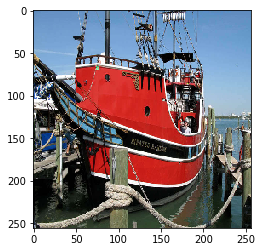

In [15]:
_,img=read_image(train_list[800])
print(img.shape)
plt.imshow(img)

(256, 256, 3)


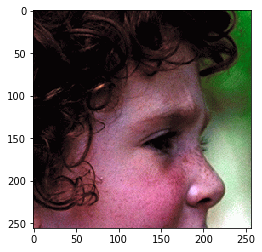

In [71]:
_,img=read_image(val_list[0])
print(img.shape)
plt.imshow(img)

## Super Resolution Model

In [54]:
def conv_block(x, filters, kernel, stride=(1,1), mode='same', act=True):
    x = K.layers.Conv2D(filters, kernel_size=kernel, strides=stride, padding=mode)(x)
    return K.layers.Activation('relu')(x) if act else x

In [55]:
def res_block(ip,nf=16):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return K.layers.Add()([x,ip])

In [140]:
def up_block(x,nf):
    x = K.layers.UpSampling2D()(x)
    x = conv_block(x,nf,kernel=(1,1))
    return x

In [141]:
def get_srmodel(shape=(None,None,3)):
    inp=K.Input(shape)

    x=conv_block(inp, 16, 3, (1,1))
    for i in range(5): x=res_block(x,16)
    

    x=up_block(x,nf=32)
#     for i in range(2): x=res_block(x,32)

#     x=up_block(x,nf=64)
#     for i in range(1): x=res_block(x,64)
    
    x = K.layers.Conv2D(3,(3,3),padding='same')(x)
    return inp,x

In [142]:
inp,outp=get_srmodel((None,None,3))
sr_model=K.Model(inp,outp)
sr_model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_20 (InputLayer)               (None, None, None, 3)   0                                                 
______________________________________________________________________________________________________________
conv2d_203 (Conv2D)                 (None, None, None, 16)  448          input_20[0][0]                       
______________________________________________________________________________________________________________
activation_98 (Activation)          (None, None, None, 16)  0            conv2d_203[0][0]                     
______________________________________________________________________________________________________________
conv2d_204 (Conv2D)                 (None, None, None, 16)  2320         activation_98[0][0]                  
_

### loading vgg for calculating perceptual loss from one of its layer

In [116]:
vgg_inp=K.Input(shape=outp.shape[1:])
vgg= K.applications.VGG16(include_top=False, 
                                  input_tensor=vgg_inp)

In [117]:
for l in vgg.layers: l.trainable=False

In [118]:
# preproc_layer = K.layers.Lambda(preproc)

In [119]:
#Here we are using vgg layer at index 36 to be the layer to calculate loss between Traget and predicted image
vgg_out_layer = vgg.get_layer(index=5).output

# making model Model(inputs, outputs)
vgg_content = K.Model(vgg_inp, vgg_out_layer)

vgg_content.summary(110)

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_19 (InputLayer)                            (None, None, None, 3)                       0                
______________________________________________________________________________________________________________
block1_conv1 (Conv2D)                            (None, None, None, 64)                      1792             
______________________________________________________________________________________________________________
block1_conv2 (Conv2D)                            (None, None, None, 64)                      36928            
______________________________________________________________________________________________________________
block1_pool (MaxPooling2D)                       (None, None, None, 64)                      0                
_

## Data Generator and Metrics

In [143]:
def randomHorizontalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 1)
    return img
def randomVerticalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 0)
    return img

In [144]:
# def randomCrop(img):
#     global input_size
#     h=input_size*2
#     assert img.shape[0] >= h
#     assert img.shape[1] >= h
#     x = random.randint(0, img.shape[1] - h)
#     y = random.randint(0, img.shape[0] - h)
#     img = img[y:y+h, x:x+h]
#     return img

In [161]:
def train_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                tar = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)
                tar = randomHorizontalFlip(tar)
                tar = randomVerticalFlip(tar)
                img1 = cv2.resize(tar, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(tar)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

# i am using Set5 dataset for validation please download the data
def valid_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(val_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_list))
            ids_valid_batch = val_list[start:end]            
            for i,ids in enumerate(ids_valid_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [146]:
l=next(valid_generator())

In [147]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [148]:
# This is our perceptual loss function
def perceptual_loss(y_true,y_pred):
#     mse=K.losses.mean_squared_error(y_true,y_pred)
    y_t=vgg_content(y_true)
    y_p=vgg_content(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

In [149]:
learning_rate=0.001
adam=K.optimizers.Adam(lr=learning_rate)
sr_model.compile(optimizer=adam,loss=perceptual_loss,metrics=[psnr,ssim])

In [150]:
batch_size=16
input_size=32

In [151]:
def fit(model,epoch=2):
    model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=epoch,
                    verbose=1,
                    validation_data=valid_generator(),
                    shuffle=True,
                    validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))
    return model

In [152]:
sr_model=fit(sr_model,10)

Epoch 1/10
135/135 [==============================] - 14s 105ms/step - loss: 5.4893 - psnr: 17.2706 - ssim: 0.5810 - val_loss: 9.8556 - val_psnr: 17.4052 - val_ssim: 0.5519
Epoch 2/10
135/135 [==============================] - 11s 78ms/step - loss: 2.3430 - psnr: 22.5427 - ssim: 0.7123 - val_loss: 8.9277 - val_psnr: 17.7453 - val_ssim: 0.5664
Epoch 3/10
135/135 [==============================] - 11s 80ms/step - loss: 2.0418 - psnr: 23.1799 - ssim: 0.7249 - val_loss: 8.5545 - val_psnr: 17.8990 - val_ssim: 0.5773
Epoch 4/10
135/135 [==============================] - 11s 80ms/step - loss: 2.0104 - psnr: 23.3667 - ssim: 0.7319 - val_loss: 8.3237 - val_psnr: 18.0475 - val_ssim: 0.5867
Epoch 5/10
135/135 [==============================] - 11s 80ms/step - loss: 1.9863 - psnr: 23.6264 - ssim: 0.7376 - val_loss: 8.2883 - val_psnr: 18.1232 - val_ssim: 0.5996
Epoch 6/10
135/135 [==============================] - 11s 81ms/step - loss: 1.9050 - psnr: 23.9630 - ssim: 0.7406 - val_loss: 8.1071 - val_

progressive resizing

In [158]:
# input_size=64
# sr_model=fit(sr_model,15)

In [159]:
# input_size=96
# sr_model=fit(sr_model,10)

In [165]:
# input_size=128
# sr_model=fit(sr_model,15)

In [162]:
input_size=160
sr_model=fit(sr_model,10)

Epoch 1/10
135/135 [==============================] - 99s 737ms/step - loss: 1.7188 - psnr: 25.2789 - ssim: 0.7644 - val_loss: 0.5919 - val_psnr: 29.4347 - val_ssim: 0.8608
Epoch 2/10
135/135 [==============================] - 97s 721ms/step - loss: 1.7140 - psnr: 25.2813 - ssim: 0.7645 - val_loss: 0.5969 - val_psnr: 29.5040 - val_ssim: 0.8593
Epoch 3/10
135/135 [==============================] - 97s 720ms/step - loss: 1.7113 - psnr: 25.2816 - ssim: 0.7645 - val_loss: 0.5965 - val_psnr: 29.3134 - val_ssim: 0.8612
Epoch 4/10
135/135 [==============================] - 97s 720ms/step - loss: 1.7071 - psnr: 25.2626 - ssim: 0.7641 - val_loss: 0.5923 - val_psnr: 29.1928 - val_ssim: 0.8606
Epoch 5/10
135/135 [==============================] - 97s 721ms/step - loss: 1.7051 - psnr: 25.2710 - ssim: 0.7641 - val_loss: 0.5826 - val_psnr: 29.4472 - val_ssim: 0.8626
Epoch 6/10
135/135 [==============================] - 97s 720ms/step - loss: 1.7030 - psnr: 25.2138 - ssim: 0.7639 - val_loss: 0.5873 -

In [167]:
input_size=224
sr_model=fit(sr_model,10)

Epoch 1/10
135/135 [==============================] - 202s 1s/step - loss: 1.2418 - psnr: 27.3299 - ssim: 0.8209 - val_loss: 0.2800 - val_psnr: 31.6454 - val_ssim: 0.9074
Epoch 2/10
135/135 [==============================] - 191s 1s/step - loss: 1.2358 - psnr: 27.4117 - ssim: 0.8217 - val_loss: 0.2768 - val_psnr: 31.3842 - val_ssim: 0.9071
Epoch 3/10
135/135 [==============================] - 191s 1s/step - loss: 1.2358 - psnr: 27.4229 - ssim: 0.8216 - val_loss: 0.2749 - val_psnr: 31.5543 - val_ssim: 0.9086
Epoch 4/10
135/135 [==============================] - 190s 1s/step - loss: 1.2341 - psnr: 27.4303 - ssim: 0.8217 - val_loss: 0.2717 - val_psnr: 31.8813 - val_ssim: 0.9100
Epoch 5/10
135/135 [==============================] - 190s 1s/step - loss: 1.2363 - psnr: 27.3482 - ssim: 0.8216 - val_loss: 0.2780 - val_psnr: 31.2999 - val_ssim: 0.9054
Epoch 6/10
135/135 [==============================] - 191s 1s/step - loss: 1.2348 - psnr: 27.3620 - ssim: 0.8217 - val_loss: 0.2788 - val_psnr: 3

In [199]:
input_size=160

In [200]:
tlr,hlr=read_image(val_list[3])
tlr=np.expand_dims(tlr,axis=0)
pred=sr_model.predict(tlr/255.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


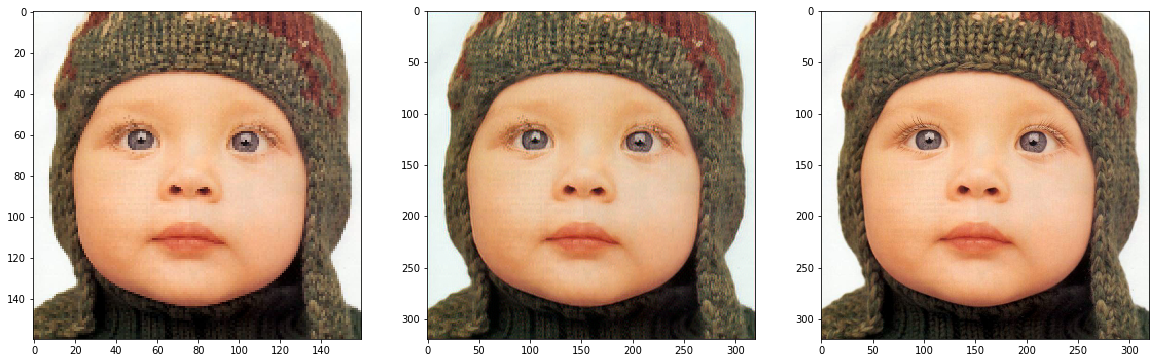

In [201]:
_,axs=plt.subplots(1,3,figsize=(20,20))
ax=axs.flat
ax[0].imshow(tlr[0]/255.)
ax[1].imshow(pred[0])
ax[2].imshow(hlr/255.)

In [171]:
K.models.save_model(sr_model,'sr_2x.h5')